In [ ]:
## Data Initializing

In [14]:
import pandas as pd
import numpy as np
import data_handler as dh
import model as md
import time
import matplotlib.pyplot as plt
from matplotlib import rc
import pickle

In [ ]:
import importlib
importlib.reload(dh)
importlib.reload(md)

In [15]:
import numba
numba.__version__

'0.49.0'

# Stable Dynamics Model

parameter $\mu = 0$

In [15]:
sd_save = 'stable_dynamics_results/'
net_name = 'Anaheim_net.tntp'
trips_name = 'Anaheim_trips.tntp'

In [16]:
handler = dh.DataHandler()
graph_correspondences, total_od_flow = handler.GetGraphCorrespondences(trips_name)
graph_data = handler.GetGraphData(net_name, columns = ['init_node', 'term_node', 'capacity', 'free_flow_time'])
init_capacities = graph_data['graph_table']['capacity'] * 2.5

## Base flows
First of all, we should find admissible set of flows on the transport graph. It is required for defining duality gap.

In [25]:
alpha = 0.75
graph_data['graph_table']['capacity'] = init_capacities * alpha
model = md.Model(graph_data, graph_correspondences,
                 total_od_flow, mu = 0)

graph_data['graph_table'].head()

,init_node,init_node_thru,term_node,term_node_thru,capacity,free_flow_time
0,1,False,117,True,16875.0,1.090458
1,2,False,87,True,16875.0,1.090458
2,3,False,74,True,16875.0,1.090458
3,4,False,233,True,16875.0,1.090458
4,5,False,165,True,16875.0,1.090458


In [27]:
assert(model.mu == 0)
max_iter = 1000

solver_kwargs = {'eps': 1e-4,
                 'max_iter': max_iter, 'stop_crit': 'max_iter',
                 'verbose': True, 'verbose_step': 200, 'save_history': True}
tic = time.time()
result = model.find_equilibrium(solver_name = 'ustm', composite = True,
                                solver_kwargs = solver_kwargs,
                                base_flows = alpha * graph_data['graph_table']['capacity'])
                                #base_flows here doesnt define anything now
toc = time.time()
print('Elapsed time: {:.0f} sec'.format(toc - tic))
print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['free_flow_time']))
print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['capacity']) - 1, end = '\n\n')

result['elapsed_time'] = toc - tic

base_flows = result['flows']

Composite optimization...
Oracles created...
Universal similar triangles method...
Primal_init = 1.24813e+06
Dual_init = -1.24813e+06
Duality_gap_init = 3.1934e+06

Iterations number: 200
Inner iterations number: 391
Primal_func_value = 1.24959e+06
Dual_func_value = -1.2634e+06
Duality_gap = 136620
Duality_gap / Duality_gap_init = 0.0427819

Iterations number: 400
Inner iterations number: 793
Primal_func_value = 1.24958e+06
Dual_func_value = -1.315e+06
Duality_gap = 85015.4
Duality_gap / Duality_gap_init = 0.0266222

Iterations number: 600
Inner iterations number: 1189
Primal_func_value = 1.24959e+06
Dual_func_value = -1.51271e+06
Duality_gap = -112692
Duality_gap / Duality_gap_init = -0.0352891

Iterations number: 800
Inner iterations number: 1589
Primal_func_value = 1.24959e+06
Dual_func_value = -1.96109e+06
Duality_gap = -561060
Duality_gap / Duality_gap_init = -0.175693

Iterations number: 1000
Inner iterations number: 1996
Primal_func_value = 1.24958e+06
Dual_func_value = -2.19885

In [30]:
#with open(sd_save + 'anaheim_' + 'ustm' + '_base_flows_max_iter_' + str(max_iter) + '_SD.pickle', 'wb') as f:
#    pickle.dump(base_flows, f)

## Model

In [20]:
with open(sd_save + 'anaheim_' + 'ustm' + '_base_flows_max_iter_' + str(1000) + '_SD.pickle', 'rb') as f:
    base_flows = pickle.load(f)

In [5]:
epsilons = np.logspace(2,0,9)
epsilons

array([100.        ,  56.23413252,  31.6227766 ,  17.7827941 ,
        10.        ,   5.62341325,   3.16227766,   1.77827941,
         1.        ])

In [21]:
graph_data['graph_table']['capacity'] = init_capacities
model = md.Model(graph_data, graph_correspondences,
                 total_od_flow, mu = 0)

graph_data['graph_table'].head()

,init_node,init_node_thru,term_node,term_node_thru,capacity,free_flow_time
0,1,False,117,True,22500.0,1.090458
1,2,False,87,True,22500.0,1.090458
2,3,False,74,True,22500.0,1.090458
3,4,False,233,True,22500.0,1.090458
4,5,False,165,True,22500.0,1.090458


## Universal Similar Triangles

In [55]:
assert(model.mu == 0)
max_iter = 40000
for index, eps_abs in enumerate(epsilons):
    print('eps_abs =', eps_abs)
    solver_kwargs = {'eps_abs': eps_abs,
                     'max_iter': max_iter, 'stop_crit': 'dual_gap',
                     'verbose': True, 'verbose_step': 2000, 'save_history': True}
    tic = time.time()
    result = model.find_equilibrium(solver_name = 'ustm', composite = True,
                                    solver_kwargs = solver_kwargs, base_flows = base_flows)
    toc = time.time()
    print('Elapsed time: {:.0f} sec'.format(toc - tic))
    print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['free_flow_time']))
    print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['capacity']) - 1, end = '\n\n')

    result['eps_abs'] = eps_abs
    result['elapsed_time'] = toc - tic
    with open(sd_save + 'anaheim_result_' + 'ustm' + '_eps_abs_' + str(index) + '_SD.pickle', 'wb') as f:
        pickle.dump(result, f)

eps_abs = 100.0
Composite optimization...
Oracles created...
Universal similar triangles method...
Primal_init = 1.24813e+06
Dual_init = -1.24813e+06
Duality_gap_init = 290.05

Result: success
Total iters: 12
Primal_func_value = 1.24815e+06
Dual_func_value = -1.24822e+06
Duality_gap = 74.4369
Duality_gap / Duality_gap_init = 0.256635
Oracle elapsed time: 2 sec
Elapsed time: 2 sec
Time ratio = 2.375977664380495
Flow excess = 0.02591664794114701

eps_abs = 56.23413251903491
Composite optimization...
Oracles created...
Universal similar triangles method...
Primal_init = 1.24813e+06
Dual_init = -1.24813e+06
Duality_gap_init = 290.05

Result: success
Total iters: 13
Primal_func_value = 1.2482e+06
Dual_func_value = -1.24822e+06
Duality_gap = 33.5391
Duality_gap / Duality_gap_init = 0.115632
Oracle elapsed time: 3 sec
Elapsed time: 3 sec
Time ratio = 2.2284658608943966
Flow excess = 0.008417261433127488

eps_abs = 31.622776601683793
Composite optimization...
Oracles created...
Universal simil

In [ ]:
#index += 9
#epsilons = [300, 200]

## Universal Gradient Descent

In [7]:
#weighted t added
assert(model.mu == 0)
max_iter = 40000
for index, eps_abs in enumerate(epsilons):
    print('eps_abs =', eps_abs)
    solver_kwargs = {'eps_abs': eps_abs,
                     'max_iter': max_iter, 'stop_crit': 'dual_gap',
                     'verbose': True, 'verbose_step': 2000, 'save_history': True}
    tic = time.time()
    result = model.find_equilibrium(solver_name = 'ugd', composite = True,
                                    solver_kwargs = solver_kwargs, base_flows = base_flows)
    toc = time.time()
    print('Elapsed time: {:.0f} sec'.format(toc - tic))
    print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['free_flow_time']))
    print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['capacity']) - 1, end = '\n\n')
    
    result['eps_abs'] = eps_abs
    result['elapsed_time'] = toc - tic
    with open(sd_save + 'anaheim_result_' + 'ugd' + '_eps_abs_' + str(index) + '_SD.pickle', 'wb') as f:
        pickle.dump(result, f)

eps_abs = 100.0
Composite optimization...
Oracles created...
Universal gradient descent method...
Primal_init = 1.24813e+06
Dual_init = -1.24813e+06
Duality_gap_init = 290.05

Result: success
Total iters: 13
Primal_func_value = 1.24815e+06
Dual_func_value = -1.24822e+06
Duality_gap = 66.7422
Duality_gap / Duality_gap_init = 0.230106
Oracle elapsed time: 4 sec
Elapsed time: 4 sec
Time ratio = 2.2966935738764516
Flow excess = 0.024609465673706588

eps_abs = 56.23413251903491
Composite optimization...
Oracles created...
Universal gradient descent method...
Primal_init = 1.24813e+06
Dual_init = -1.24813e+06
Duality_gap_init = 290.05

Result: success
Total iters: 16
Primal_func_value = 1.24819e+06
Dual_func_value = -1.24821e+06
Duality_gap = 47.6771
Duality_gap / Duality_gap_init = 0.164375
Oracle elapsed time: 4 sec
Elapsed time: 4 sec
Time ratio = 2.1329871312054576
Flow excess = 0.013117561393799493

eps_abs = 31.622776601683793
Composite optimization...
Oracles created...
Universal grad

In [ ]:
#index += 9
#epsilons = [300, 200]

## Weighted Dual Averages

### Composite optimization

In [9]:
assert(model.mu == 0)
max_iter = 50000
solver_kwargs = {'max_iter': max_iter, 'stop_crit': 'max_iter',
                 'verbose': True, 'verbose_step': 4000, 'save_history': True}
tic = time.time()
result = model.find_equilibrium(solver_name = 'wda', composite = True, 
                                solver_kwargs = solver_kwargs, base_flows = base_flows)
toc = time.time()
print('Elapsed time: {:.0f} sec'.format(toc - tic))
print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['free_flow_time']))
print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['capacity']) - 1, end = '\n\n')

result['elapsed_time'] = toc - tic
with open(sd_save + 'anaheim_result_' + 'wda' + '_max_iter_' + str(max_iter) + '_SD.pickle', 'wb') as f:
    pickle.dump(result, f)

Composite optimization...
Oracles created...
Weighted dual averages method...
Primal_init = 1.24813e+06
Dual_init = -1.24813e+06
Duality_gap_init = 290.05

Iterations number: 4000
Primal_func_value = 1.2482e+06
Dual_func_value = -1.24822e+06
Duality_gap = 20.728
Duality_gap / Duality_gap_init = 0.0714635

Iterations number: 8000
Primal_func_value = 1.2482e+06
Dual_func_value = -1.24822e+06
Duality_gap = 14.3112
Duality_gap / Duality_gap_init = 0.0493405

Iterations number: 12000
Primal_func_value = 1.24821e+06
Dual_func_value = -1.24822e+06
Duality_gap = 11.5552
Duality_gap / Duality_gap_init = 0.0398387

Iterations number: 16000
Primal_func_value = 1.24821e+06
Dual_func_value = -1.24822e+06
Duality_gap = 9.94551
Duality_gap / Duality_gap_init = 0.0342889

Iterations number: 20000
Primal_func_value = 1.24821e+06
Dual_func_value = -1.24822e+06
Duality_gap = 8.85476
Duality_gap / Duality_gap_init = 0.0305284

Iterations number: 24000
Primal_func_value = 1.24821e+06
Dual_func_value = -1.2

### Non-composite optimization

In [10]:
assert(model.mu == 0)
max_iter = 50000
solver_kwargs = {'max_iter': max_iter, 'stop_crit': 'max_iter',
                 'verbose': True, 'verbose_step': 4000, 'save_history': True}
tic = time.time()
result = model.find_equilibrium(solver_name = 'wda', composite = False, 
                                solver_kwargs = solver_kwargs, base_flows = base_flows)
toc = time.time()
print('Elapsed time: {:.0f} sec'.format(toc - tic))
print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['free_flow_time']))
print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['capacity']) - 1, end = '\n\n')

result['elapsed_time'] = toc - tic
with open(sd_save + 'anaheim_result_' + 'wda_noncomposite' + '_max_iter_' + str(max_iter) + '_SD.pickle', 'wb') as f:
    pickle.dump(result, f)

Non-composite optimization...
Oracles created...
Weighted dual averages method...
Primal_init = 1.24813e+06
Dual_init = -1.24813e+06
Duality_gap_init = 290.05

Iterations number: 4000
Primal_func_value = 1.24816e+06
Dual_func_value = -1.24819e+06
Duality_gap = 84.9128
Duality_gap / Duality_gap_init = 0.292752

Iterations number: 8000
Primal_func_value = 1.24816e+06
Dual_func_value = -1.2482e+06
Duality_gap = 70.9427
Duality_gap / Duality_gap_init = 0.244588

Iterations number: 12000
Primal_func_value = 1.24817e+06
Dual_func_value = -1.24821e+06
Duality_gap = 55.6904
Duality_gap / Duality_gap_init = 0.192003

Iterations number: 16000
Primal_func_value = 1.24818e+06
Dual_func_value = -1.24821e+06
Duality_gap = 47.0835
Duality_gap / Duality_gap_init = 0.162329

Iterations number: 20000
Primal_func_value = 1.24818e+06
Dual_func_value = -1.24821e+06
Duality_gap = 41.4179
Duality_gap / Duality_gap_init = 0.142796

Iterations number: 24000
Primal_func_value = 1.24818e+06
Dual_func_value = -1.

## Plots

In [24]:
%matplotlib inline
from matplotlib import pyplot as plt

In [25]:
results = {}

for method in ['ustm', 'ugd']:
    results[method] = {}
    results[method]['iters'] = []
    results[method]['inner_iters'] = []
    results[method]['epsilon'] = []
    i = 0
    while True:
        try:
            with open(sd_save + 'anaheim_result_' + method + '_eps_abs_'
                      + str(i) + '_SD.pickle', 'rb') as f:
                result = pickle.load(f)
                results[method]['epsilon'].append(result['eps_abs'])
                results[method]['iters'].append(result['iter_num'])
                results[method]['inner_iters'].append(result['history'].get('inner_iters')[-1])       
        except FileNotFoundError:
            break
        i += 1

In [26]:
for method in ['wda', 'wda_noncomposite']:
    results[method] = {}
    with open(sd_save + 'anaheim_result_' + method + '_max_iter_50000_SD.pickle', 'rb') as f:
        result = pickle.load(f)
        results[method]['epsilon'] = result['history'].get('dual_gap')
        results[method]['iters'] = result['history'].get('iter')

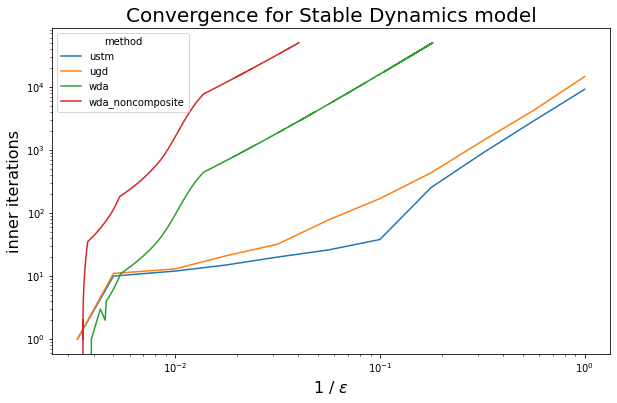

In [36]:
plt.figure(figsize=(10,6))
plt.title('Convergence for Stable Dynamics model', fontsize=20)
eps_upper = 300 #200
for method, data in results.items():
    x = 1. / np.array(data['epsilon'])
    x_inds = np.argsort(x)
    x = x[x_inds]
    if 'inner_iters' in data:
        y = np.array(data['inner_iters'])[x_inds]
    else:
        y = np.array(data['iters'])[x_inds]
    ind = np.nonzero(1 / x <= eps_upper)
    plt.plot(x[ind], y[ind], label = method)
plt.legend(title = 'method')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'1 / $\varepsilon$', fontsize = 16)
plt.ylabel('inner iterations', fontsize = 16)
#plt.savefig('SD_convergence_1.jpg', dpi = 300)
plt.show()